Dieses Notebook habe ich nur verwendet um mit dem erwähnten Paper ein bisschen vertraut zu werden, es gehört also nicht zur Abgabe.
Das ganze habe ich zu dem hier weitergeführt: https://app.semap.ch/date ([Source Code](https://gitlab.com/sacovo/swiss-magic-wall))

In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In diesem Notebook geht es darum, eine Hochrechnung für Abstimmungsresultate zu berechnen. Grundlage für diese Berechnungen ist das Paper ["Sub-Matrix Factorization for Real-Time Vote Prediction"](https://infoscience.epfl.ch/record/278872) von Immer Alexander, Kristof Victor, Grossglauser Matthias und Thiran Patrick.

Der Algorithmus basiert auf den Resultaten von früheren Abstimmungen, daraus wird ein GLM berechnet, mit dem eine Prognose für die fehlenden Gemeinden berechnet werden können. Diese Prognosen können dann zusammengerechnet werden.

In [2]:
results = pd.read_csv(
    'data/abstimmungen.csv', na_values=['...']
).rename(
    columns={
        "Kanton (-) / Bezirk (>>) / Gemeinde (......)": "Gemeinde"
    }
).dropna()

results['Gemeinde'] = results['Gemeinde'].str.replace(
    r'\.\.\.\.\.\.', ''
).replace(
    "Brione (Verzasca)",
    "Verzasca",
).replace(
    "La Punt-Chamues-ch",
    "La Punt Chamues-ch"
)

In [3]:
yes_pivot = results.pivot(index="Gemeinde", columns="Datum und Vorlage", values="Ja in %").reset_index().dropna()
yes_pivot.columns.name = None
yes_pivot.set_index("Gemeinde", inplace=True)

part_pivot = results.pivot(index="Gemeinde", columns="Datum und Vorlage", values="Beteiligung in %").reset_index().dropna()
part_pivot.columns.name = None
part_pivot.set_index("Gemeinde", inplace=True)

people = results.pivot(index="Gemeinde", columns="Datum und Vorlage", values="Stimmberechtigte").reset_index().dropna()
people.columns.name = None
people.set_index("Gemeinde", inplace=True)

In [4]:
latest_vote = "2020-09-27 Volksinitiative «Für eine massvolle Zuwanderung (Begrenzungsinitiative)»"

In [5]:
yes_matrix = yes_pivot.fillna(yes_pivot.mean()).to_numpy()
part_matrix = part_pivot.fillna(part_pivot.mean()).to_numpy()

In [6]:
Y_v = yes_matrix[:,:-1]
Y_p = part_matrix[:,:-1]

new_votes = yes_matrix[:,-1:]
new_parts = part_matrix[:,-1:]

Die Berechnung des Prognose folgt in folgenden Methoden. Zuerst wird aus allen alten Resultaten eine Matrix berechnet, mit der die Hochrechnung berechnet werden könnnen. Diese Methode muss nur einmal ausgeführt werden.
Mit jedem neuen Zwischenresultat wird dann die zweite Methode aufgerufen, die daraus eine Hocherchnung berechnet.

In [7]:
def calculate_projection(Y):
    u, s, v = np.linalg.svd(Y, full_matrices=False)
    s = np.diag(s)
    return np.dot(u, s)


def prediction(X, y, I):
    X_o = X[I]
    
    tmp = np.linalg.inv((np.dot(X_o.T, X_o) + 0.01 * np.identity(X.shape[1])))
    tmp2 = np.dot(tmp, X_o.T)
    w = np.dot(tmp2, y[I])
    return np.dot(X, w)

In [8]:
X_v = calculate_projection(Y_v)
X_p = calculate_projection(Y_p)

Um aus den prognoszierten Prozentwerten eine Hochrechnung für die ganze Schweiz berechnen können, müssen wir noch die Anzahl der Stimmberechtigten pro Gemeinde wissen. Dazu nehmen wir die Resultate aus der letzten Abstimmung.

In [9]:
yes_pivot['people'] = people[latest_vote].to_numpy()

Jetzt können wir die Hochrechnung machen, weil wir bereits alle Resultate haben, nehmen wir zufällig n Resultate und berechnen daraus die anderen Endresultate.

In [10]:
yes_pivot['vote-f'] = new_votes
yes_pivot['part-f'] = new_parts

yes_pivot['abs-f'] = yes_pivot['vote-f'] / 100 * yes_pivot['part-f'] / 100 * yes_pivot['people']

yes_pivot['abs-no-f'] = (100 - yes_pivot['vote-f']) / 100 * yes_pivot['part-f'] / 100 * yes_pivot['people']


total_yes_f = yes_pivot['abs-f'].sum()
total_no_f = yes_pivot['abs-no-f'].sum()

final_result = total_yes_f / (total_yes_f + total_no_f)

print("Final result:", final_result)

Final result: 0.38369029585171693


Wir sind also bereits mit 100 Gemeinden ziemlich nahe am Schlussresultat. Als nächstes können wir mit den gleichen Methoden auch die Wahlbeteiligung vorhersagen und in das Endresultat einfliessen lassen.

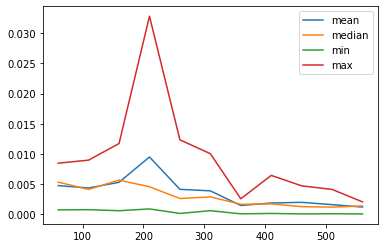

In [75]:
ns = []
mean_errors = []
median_errors = []
min_errors = []
max_errors = []
np.random.seed(10)

for n in range(60, 600, 50):
    errors = []
    for i in range(10):

        chosen = np.random.choice(np.array(range(len(new_votes))), n, replace=False)

        indexes = np.array(range(len(new_votes)), dtype=bool)
        indexes[:] = False
        indexes[chosen] = True

        vote_p = prediction(X_v, new_votes, indexes)
        yes_pivot['vote-p'] = vote_p

        part_p = prediction(X_p, new_parts, indexes)
        yes_pivot['part-p'] = part_p

        yes_pivot['abs-p'] = yes_pivot['vote-p'] / 100 * yes_pivot['part-p'] / 100  * yes_pivot['people']
        yes_pivot['abs-no-p'] = (100 - yes_pivot['vote-p']) /  100 * yes_pivot['part-p'] / 100  * yes_pivot['people']

        yes_pivot['diff'] = np.abs(yes_pivot['abs-p'] - yes_pivot['abs-f'])

        total_yes_p = yes_pivot['abs-p'].sum()
        total_no_p = yes_pivot['abs-no-p'].sum()
        predicted_result =  total_yes_p / (total_no_p + total_yes_p)
        err = np.abs(final_result - predicted_result)
        errors.append(err)
    
    errors = pd.Series(errors)
    ns.append(n)
    mean_errors.append(errors.mean())
    median_errors.append(errors.median())
    min_errors.append(errors.min())
    max_errors.append(errors.max())

plt.plot(ns, mean_errors, label="mean")
plt.plot(ns, median_errors, label="median")
plt.plot(ns, min_errors, label="min")
plt.plot(ns, max_errors, label="max")
plt.legend()

In [74]:
chosen = np.random.choice(np.array(range(len(new_votes))), 210, replace=False)

indexes = np.array(range(len(new_votes)), dtype=bool)
indexes[:] = False
indexes[chosen] = True

vote_p = prediction(X_v, new_votes, indexes)
yes_pivot['vote-p'] = vote_p

part_p = prediction(X_p, new_parts, indexes)
yes_pivot['part-p'] = part_p

yes_pivot['abs-p'] = yes_pivot['vote-p'] / 100 * yes_pivot['part-p'] / 100  * yes_pivot['people']
yes_pivot['abs-no-p'] = (100 - yes_pivot['vote-p']) /  100 * yes_pivot['part-p'] / 100  * yes_pivot['people']

yes_pivot['diff'] = np.abs(yes_pivot['abs-p'] - yes_pivot['abs-f'])

total_yes_p = yes_pivot['abs-p'].sum()
total_no_p = yes_pivot['abs-no-p'].sum()
predicted_result =  total_yes_p / (total_no_p + total_yes_p)
err = np.abs(final_result - predicted_result)
err

0.0006034794821040967